This is a notebook to build vanillia transformer form scratch.

Orinigal paper: https://arxiv.org/abs/1706.03762

Make reference to: https://www.tensorflow.org/tutorials/text/transformer

In [4]:
import tensorflow as tf
import numpy as np
import math
from IPython.display import Image

### Positional ecoding

Notes to positional encoding:

1. Input 
    
    L: Length of sequence (number of words in a sentence)
    
    d: number of neuron in later encoder/decoder layer

3. Output is a 3-D array (1, batch size, d_model) which to be added with embedding layer

   Formula:
$$\large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

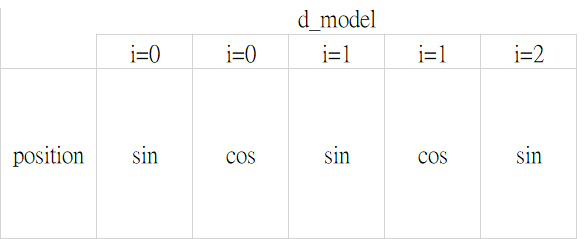

In [5]:
'''
Graphical visualization
'''
Image(filename = "positional encoding.png", width = 400, height = 300)


In [3]:
np.set_printoptions(suppress=True)

def positional_encoding(L,d): 
  X=(np.zeros((d,L))+np.arange(L)).T
  X=X/(10000**(2*(np.arange(d)//2)/d))
  X[:,0::2]=np.sin(X[:,0::2])
  X[:,1::2]=np.cos(X[:,1::2])
  X=X[np.newaxis,:]
  return tf.cast(X, dtype=tf.float32)

## Scaled dot product attaention

Input shape
q,k,v dimension 4D array (batch_size, number of heads, Length of sequence, depth)

Output shape
(batch size, number of heads, depth)

Encoder:

1. q,k and v are all come from X, the input vector

2. Masking is not needed

Decoder:

1. q is the decoder output, while k and v are the same encoder output

2. Masking is needed

$$\small{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [4]:
def scaled_dot_product_attention(q,k,v,mask):
  QK=tf.matmul(q,k,transpose_b=True)/tf.math.sqrt(tf.cast(tf.shape(k)[-1],tf.float32))
  if mask is not None:
    QK+= mask * -1e9
  weight=tf.nn.softmax(QK,axis=-1)
  otuput=tf.matmul(weight,v)
  return otuput, weight

### Multihead attention

input shape: batch size, sequence length, model depth


output shape: batch size, head size, sequence length, number of neuron in each head 

(model depth = head size x number of neuron in each head)

In [5]:
class multihead_attention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,name='Multihead'):
        super(multihead_attention,self).__init__()
        self.num_heads=num_heads
        self.d_model=d_model
        self.depth=self.d_model//self.num_heads

        self.q_layer=tf.keras.layers.Dense(self.d_model)
        self.k_layer=tf.keras.layers.Dense(self.d_model)
        self.v_layer=tf.keras.layers.Dense(self.d_model)

        self.dense=tf.keras.layers.Dense(self.d_model)
    def call(self,q,k,v,mask):
        batch_size=tf.shape(q)[0]

        q=self.q_layer(q)
        k=self.k_layer(k)
        v=self.v_layer(v)

        #(batch_size, num_heads, seq_len_, depth)
        q=tf.reshape(q,(batch_size,-1,self.num_heads,self.depth))
        q=tf.transpose(q,perm=[0,2,1,3]) 
        k=tf.reshape(k,(batch_size,-1,self.num_heads,self.depth))
        k=tf.transpose(k,perm=[0,2,1,3])
        v=tf.reshape(v,(batch_size,-1,self.num_heads,self.depth))
        v=tf.transpose(v,perm=[0,2,1,3])
        
        scaled_attention, attention_weights=scaled_dot_product_attention(q,k,v,mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) #(B,L,H,D)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model)) 
        concat_attention=self.dense(concat_attention)

        return concat_attention,attention_weights

### Enocder Block
The whole block of encoder layer consist of:

1. multihead attention
2. layer normalization (residual connection)
3.feed forward network
    3.1 Dense layer sized 2048 with Relu activation
    3.2 Dense layer sized 512
4.layer normalization (residual connection)

In [6]:
class encoder_layer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,ffn,drop_rate=0.1):
        super(encoder_layer,self).__init__()
        self.drop_rate=drop_rate
        self.ffn=ffn
        self.num_heads=num_heads
        self.d_model=d_model
        
        self.mha=multihead_attention(self.d_model,self.num_heads)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.Drop1=tf.keras.layers.Dropout(self.drop_rate)
        self.Drop2=tf.keras.layers.Dropout(self.drop_rate)
        
        self.Dense1=tf.keras.layers.Dense(self.ffn, activation='relu')
        self.Dense2=tf.keras.layers.Dense(d_model)

    def call(self,X,training,mask):
        X_shortcut=X #first residual
        X,_=self.mha(X,X,X,mask)

        X=self.Drop1(X,training=training)
        X=self.layernorm1(X+X_shortcut)
        
        X_shortcut=X #second residual
        '''
        Feed forward network
        '''
        X=self.Dense1(X)
        X=self.Dense2(X)
        X=self.Drop2(X,training=training)
        X=self.layernorm2(X+X_shortcut)
        
        return X

## Notes to Embedding layer
https://keras.io/api/layers/core_layers/embedding/


Input shape: (batch size, input vocab size), not batch input length


Output shape: (batch size, input vocab size, d_model)

In [7]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, d_model, input_vocab_size,
                 num_heads, ffn, num_layers=6, drop_rate=0.1):
        super(Encoder,self).__init__()
        self.d_model=d_model
        self.input_vocab_size=input_vocab_size
        self.num_heads=num_heads
        self.drop_rate=drop_rate
        self.ffn=ffn
        self.num_layers=num_layers

        self.embedding=tf.keras.layers.Embedding(self.input_vocab_size,self.d_model)
        self.position=positional_encoding(self.input_vocab_size, self.d_model)
        self.Dropout=tf.keras.layers.Dropout(self.drop_rate)
        self.encoder_layers=[encoder_layer(self.num_heads,self.d_model,self.ffn,self.drop_rate) 
                            for _ in range(self.num_layers)]
        
    def call(self,X_input,training,mask):
        input_length=tf.shape(X_input)[1]

        X=self.embedding(X_input)
        X*=tf.math.sqrt(tf.cast(self.d_model,dtype=tf.float32)) #See paper 3.4
        X_pos=self.position[:,:input_length,:]     
        X+=X_pos
        X=self.Dropout(X,training=training)

        for i in range(self.num_layers):
            X=self.encoder_layers[i](X,training,mask)
        return X
    

### Decoder Block

The whole block of decoder layer consist of:

1. masked multihead attention
2. layer normalization (residual connection)
3. multihead attention
4. layer normalization (residual connection)
5.feed forward network

    5.1 Dense layer sized 2048 with Relu activation
    
    5.2 Dense layer sized 512
6.layer normalization (residual connection)

In [8]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [9]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [10]:
class decoder_layer(tf.keras.layers.Layer):
    def __init__(self, d_model,ffn, num_heads, drop_rate=0.1):
        super(decoder_layer,self).__init__()
        self.d_model=d_model
        self.ffn=ffn
        self.drop_rate=drop_rate
        self.num_heads=num_heads
        
        self.mha_mask=multihead_attention(self.d_model,self.num_heads)
        self.mha=multihead_attention(self.d_model,self.num_heads)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.Dropout1 = tf.keras.layers.Dropout(self.drop_rate)
        self.Dropout2 = tf.keras.layers.Dropout(self.drop_rate)
        self.Dropout3 = tf.keras.layers.Dropout(self.drop_rate)
        
        self.Dense1=tf.keras.layers.Dense(self.ffn, activation='relu')
        self.Dense2=tf.keras.layers.Dense(d_model)
        
    def call(self,Y,encoder_output,training,look_ahead_mask,padding_mask):
        Y_shortcut=Y
        Y,attn_weights_block1=self.mha_mask(Y,Y,Y,look_ahead_mask) 
        Y=self.Dropout1(Y,training=training)
        Y=self.layernorm1(Y+Y_shortcut)
        
        Y_shortcut=Y
        Y,attn_weights_block2=self.mha(Y,encoder_output,encoder_output,padding_mask)
        Y=self.Dropout2(Y,training=training)
        Y=self.layernorm2(Y+Y_shortcut)

        Y_shortcut=Y
        Y=self.Dense1(Y)
        Y=self.Dense2(Y)
        Y=self.Dropout3(Y,training=training)
        Y=self.layernorm3(Y+Y_shortcut)

        return Y, attn_weights_block1, attn_weights_block2
        

In [11]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,d_model,target_vocab_size,num_heads,ffn,num_layers=6,drop_rate=0.1):
        super(Decoder,self).__init__()
        self.d_model=d_model
        self.num_heads=num_heads
        self.ffn=ffn
        self.drop_rate=drop_rate
        self.target_vocab_size=target_vocab_size
        self.num_layers=num_layers
        
        self.embedding=tf.keras.layers.Embedding(self.target_vocab_size,self.d_model)
        self.position=positional_encoding(self.target_vocab_size, self.d_model)
        self.Dropout1=tf.keras.layers.Dropout(self.drop_rate)
        self.decoder_layers=[decoder_layer(self.d_model,self.ffn, self.num_heads, self.drop_rate) 
                             for _ in range(self.num_layers)]

    def call(self,Y_input,encoder_output,training,look_ahead_mask, padding_mask):
        target_length = tf.cast(tf.shape(Y_input)[1],dtype=tf.int32)

        attention_weights = {}
        Y=self.embedding(Y_input)
        Y*=tf.math.sqrt(tf.cast(self.d_model,dtype=tf.float32)) #See Section 3.4
        Y_pos=self.position[:,:target_length,:]  
        
        Y+=Y_pos
        Y=self.Dropout1(Y,training=training)

        for i in range(self.num_layers):
            Y,block1,block2=self.decoder_layers[i](Y,encoder_output,training,look_ahead_mask, padding_mask)
        
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return Y,attention_weights

In [37]:
class Transformer(tf.keras.Model):
    def __init__(self,d_model, input_vocab_size, target_vocab_size, 
                  num_heads, ffn, num_layers, drop_rate):
        super(Transformer,self).__init__()
        self.d_model=d_model
        self.input_vocab_size=input_vocab_size
        self.target_vocab_size=target_vocab_size
        self.num_heads=num_heads
        self.ffn=ffn
        self.drop_rate=drop_rate
        self.num_layers=num_layers
        
        self.encod=Encoder(self.d_model, self.input_vocab_size,
                           self.num_heads,self.ffn,self.num_layers,self.drop_rate)
        self.decod=Decoder(self.d_model, self.target_vocab_size,
                           self.num_heads,self.ffn,self.num_layers,self.drop_rate)
        self.linear=tf.keras.layers.Dense(self.target_vocab_size, activation='softmax')
        
    def call(self,X_input, Y_input, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        X=self.encod(X_input,training, enc_padding_mask)
        X,attention_weights=self.decod(Y_input, X, training, look_ahead_mask, dec_padding_mask)
        output=self.linear(X)

        return output,attention_weights

In [13]:
#Let's follow the remaining step in the tutorial to check the performance of the model

In [14]:
import tensorflow_datasets as tfds
import time

In [15]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [16]:
'Visualize the data'
sample=(list(iter(train_examples))[0])
print(sample[0])
print(sample[1])

tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)


In [17]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [19]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [20]:
pt_batch, en_batch = next(iter(train_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8214,  119,    1, ...,    0,    0,    0],
        [8214,    6,   70, ...,    0,    0,    0],
        [8214,    7, 2533, ...,    0,    0,    0],
        ...,
        [8214,    6, 4051, ...,    0,    0,    0],
        [8214, 7847,  628, ...,    0,    0,    0],
        [8214,  802,  277, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 36), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    2, 8088,    0],
        [8087,    4,   19, ...,    0,    0,    0],
        [8087,    3, 7210, ...,    0,    0,    0],
        ...,
        [8087,    4,   14, ...,    0,    0,    0],
        [8087,   12,   31, ...,    0,    0,    0],
        [8087,  750, 2879, ...,    0,    0,    0]])>)

Learning rate

$$\small{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
learning_rate = CustomSchedule(d_model=512)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [24]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [25]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [38]:
transformer = Transformer(d_model=512, input_vocab_size=tokenizer_pt.vocab_size + 2, 
                          target_vocab_size=tokenizer_en.vocab_size + 2,
                          num_heads=8, ffn=2048, num_layers=2,drop_rate=0.1)

In [27]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [43]:
EPOCHS = 10

In [44]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask,combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [45]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,train_loss.result(),train_accuracy.result()))
  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 7.4621 Accuracy 0.0858
Epoch 1 Batch 50 Loss 6.3468 Accuracy 0.1220
Epoch 1 Batch 100 Loss 5.9759 Accuracy 0.1649
Epoch 1 Batch 150 Loss 5.7243 Accuracy 0.1928
Epoch 1 Batch 200 Loss 5.5363 Accuracy 0.2129
Epoch 1 Batch 250 Loss 5.4055 Accuracy 0.2267
Epoch 1 Batch 300 Loss 5.2994 Accuracy 0.2381
Epoch 1 Batch 350 Loss 5.2102 Accuracy 0.2473
Epoch 1 Batch 400 Loss 5.1296 Accuracy 0.2561
Epoch 1 Batch 450 Loss 5.0542 Accuracy 0.2648
Epoch 1 Batch 500 Loss 4.9816 Accuracy 0.2733
Epoch 1 Batch 550 Loss 4.9153 Accuracy 0.2814
Epoch 1 Batch 600 Loss 4.8525 Accuracy 0.2892
Epoch 1 Batch 650 Loss 4.7942 Accuracy 0.2963
Epoch 1 Batch 700 Loss 4.7392 Accuracy 0.3033
Epoch 1 Loss 4.7376 Accuracy 0.3034
Time taken for 1 epoch: 115.91195440292358 secs

Epoch 2 Batch 0 Loss 3.8999 Accuracy 0.3890
Epoch 2 Batch 50 Loss 3.8268 Accuracy 0.4109
Epoch 2 Batch 100 Loss 3.7887 Accuracy 0.4156
Epoch 2 Batch 150 Loss 3.7676 Accuracy 0.4182
Epoch 2 Batch 200 Loss 3.7395 Accuracy 0.4216
E

In [46]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, output,False,enc_padding_mask,combined_mask,dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [47]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result if i < tokenizer_en.vocab_size], fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [48]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [49]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to deal with .
Real translation: this is a problem we have to solve .


In [50]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea.
Real translation: and my neighboring homes heard about this idea .


In [51]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to share with you a few stories of some magic things that have happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .
